# Kindle Review Sentiment Analysis with Word2Vec (Google News 300)

This notebook demonstrates how to:
1. Load and preprocess Kindle reviews.
2. Use the pretrained **Google News Word2Vec (300-dim)** model.
3. Generate review embeddings.
4. Train classifiers (RandomForest) for sentiment prediction.
5. Analyze and visualize embeddings and model results.


In [ ]:

!pip install gensim


In [1]:

import pandas as pd
import gensim.downloader as api
import nltk
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:

df = pd.read_csv("Data/all_kindle_review.csv")
df.head()


,Unnamed: 0.1,Unnamed: 0,asin,helpful,rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,11539,B0033UV8HI,"[8, 10]",3,"Jace Rankin may be short, but he's nothing to ...","09 2, 2010",A3HHXRELK8BHQG,Ridley,Entertaining But Average,1283385600
1,1,5957,B002HJV4DE,"[1, 1]",5,Great short read. I didn't want to put it dow...,"10 8, 2013",A2RGNZ0TRF578I,Holly Butler,Terrific menage scenes!,1381190400
2,2,9146,B002ZG96I4,"[0, 0]",3,I'll start by saying this is the first of four...,"04 11, 2014",A3S0H2HV6U1I7F,Merissa,Snapdragon Alley,1397174400
3,3,7038,B002QHWOEU,"[1, 3]",3,Aggie is Angela Lansbury who carries pocketboo...,"07 5, 2014",AC4OQW3GZ919J,Cleargrace,very light murder cozy,1404518400
4,4,1776,B001A06VJ8,"[0, 1]",4,I did not expect this type of book to be in li...,"12 31, 2012",A3C9V987IQHOQD,Rjostler,Book,1356912000


In [4]:
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return word_tokenize(text)

reviews = df['reviewText'].dropna().astype(str).tolist()
tokenized_reviews = [clean_text(review) for review in reviews]


In [6]:
model = api.load("word2vec-google-news-300")


Loading Google News Word2Vec (300-dim)...
[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [7]:

def get_review_vector(tokens, model):
    vecs = []
    for word in tokens:
        if word in model.key_to_index:
            vecs.append(model[word])
    if len(vecs) == 0:
        return None
    return sum(vecs) / len(vecs)

review_vectors = [get_review_vector(tokens, model) for tokens in tokenized_reviews]
review_vectors = [vec for vec in review_vectors if vec is not None]

print(f"Total reviews: {len(reviews)}")
print(f"Reviews with embeddings: {len(review_vectors)}")
print(f"OOV rate: {100*(1 - len(review_vectors)/len(reviews)):.2f}%")


Total reviews: 12000
Reviews with embeddings: 12000
OOV rate: 0.00%


In [8]:

print("\nTop words similar to 'book':")
print(model.most_similar("book")[:10])

print("\nSimilarity between 'good' and 'bad':", model.similarity("good", "bad"))
print("Similarity between 'book' and 'novel':", model.similarity("book", "novel"))



Top words similar to 'book':
[('tome', 0.7485830783843994), ('books', 0.7379177808761597), ('memoir', 0.7302926778793335), ('paperback_edition', 0.6868364214897156), ('autobiography', 0.6741527318954468), ('memoirs', 0.6505153179168701), ('Book', 0.6479282975196838), ('paperback', 0.6471226811408997), ('novels', 0.6341459155082703), ('hardback', 0.6283079981803894)]

Similarity between 'good' and 'bad': 0.7190051
Similarity between 'book' and 'novel': 0.61219364


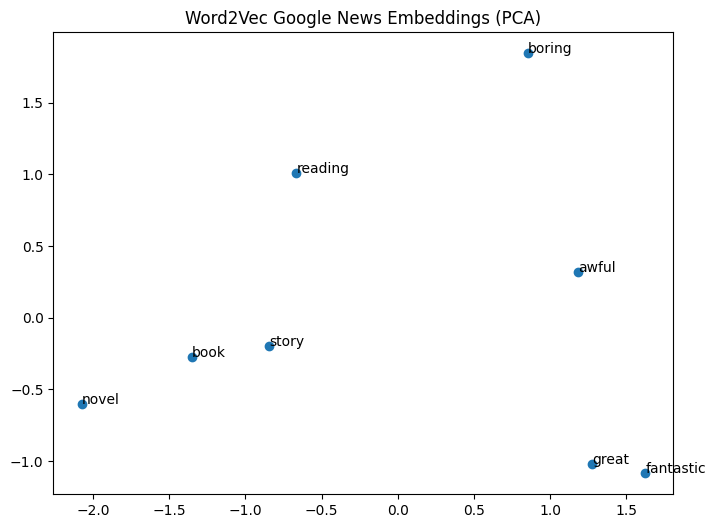

In [9]:

words = ["book", "novel", "story", "boring", "fantastic", "great", "awful", "reading"]
word_vecs = [model[w] for w in words if w in model.key_to_index]

pca = PCA(n_components=2)
result = pca.fit_transform(word_vecs)

plt.figure(figsize=(8,6))
plt.scatter(result[:,0], result[:,1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i,0], result[i,1]))
plt.title("Word2Vec Google News Embeddings (PCA)")
plt.show()


In [14]:
df = df.dropna(subset=["reviewText", "rating"])

def map_sentiment(rating):
    if rating <= 2:
        return 0
    elif rating >= 4:
        return 1
    else:
        return None

df["sentiment"] = df["rating"].apply(map_sentiment)

# Drop neutral (3-star) reviews
df = df.dropna(subset=["sentiment"])
df["sentiment"] = df["sentiment"].astype(int)

print(df[["rating", "reviewText", "sentiment"]].head(10))
print(df["sentiment"].value_counts())


    rating                                         reviewText  sentiment
1        5  Great short read.  I didn't want to put it dow...          1
4        4  I did not expect this type of book to be in li...          1
5        5  Aislinn is a little girl with big dreams. Afte...          1
6        2  This has the makings of a good story... unfort...          0
7        4  I got this because I like collaborated short s...          1
8        5  Loved this book, I am hooked on this series an...          1
9        4  And that's a good thing. Short, sweet tease th...          1
10       1  I received a copy of book to review. "A secret...          0
11       4  Even though you already know what the outcome ...          1
12       1  I read the other reviews and decided to give i...          0
sentiment
1    6000
0    4000
Name: count, dtype: int64


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.70      0.75       800
           1       0.82      0.90      0.85      1200

    accuracy                           0.82      2000
   macro avg       0.82      0.80      0.80      2000
weighted avg       0.82      0.82      0.81      2000



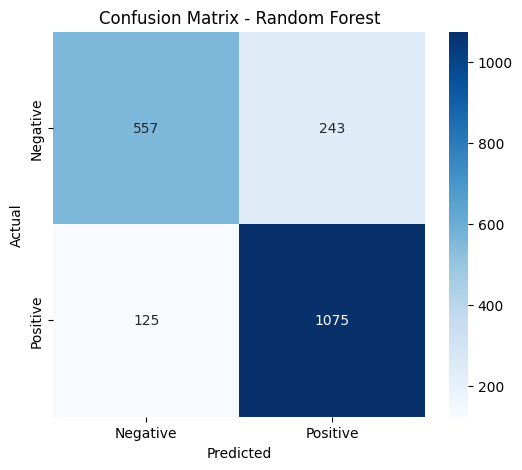

In [15]:

df = df.dropna(subset=["reviewText", "sentiment"])
reviews = df['reviewText'].astype(str).tolist()
labels = df['sentiment'].astype(int).tolist()

tokenized_reviews = [clean_text(review) for review in reviews]
review_vectors = [get_review_vector(tokens, model) for tokens in tokenized_reviews]
filtered = [(vec, label) for vec, label in zip(review_vectors, labels) if vec is not None]
X, y = zip(*filtered)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_clf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [ ]:
def predict_sentiment(review_text, model, clf):
    """Predicts the sentiment of a given review text using the trained model."""
    tokens = clean_text(review_text)
    vector = get_review_vector(tokens, model)
    if vector is None:
        return "Cannot predict: No valid words in review."
    vector = vector.reshape(1, -1)
    prediction = clf.predict(vector)
    return "Positive" if prediction[0] == 1 else "Negative"

user_review = input("Enter the review text: ")

predicted_sentiment_user = predict_sentiment(user_review, model, rf_clf)
print(f"\nReview: '{user_review}'\nPredicted Sentiment: {predicted_sentiment_user}")

Enter the review text: boring

Review: 'boring'
Predicted Sentiment: Negative
